# Import everything

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from tqdm.notebook import tqdm
import math
import multiprocessing
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from timeit import default_timer as timer
from datetime import timedelta
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz
from itertools import combinations
import openpyxl
from scipy.stats import pearsonr
from matplotlib import colors as mcolors
from functions import eegplot

# Read powers and phases

In [2]:
df_power = pd.read_csv('157-d2-power-v3.csv')
df_phase = pd.read_csv('157-d2-phase-v3.csv')

In [3]:
# Fix some columns and values for readability.
df_power.loc[df_power['EEG'] == 'Average', 'EEG'] = "M1 Average"
df_power.loc[df_power['Time'] == -250, 'Time'] = "-250ms"
df_power.loc[df_power['Time'] == -750, 'Time'] = "-750ms"
df_phase.loc[df_phase['EEG'] == 'Average', 'EEG'] = "M1 Average"
df_power = df_power.rename(columns={'ArtifactRemoved': 'Artifact Removed'})
df_phase = df_phase.rename(columns={'ArtifactRemoved': 'Artifact Removed'})
for col in ['Artifact Removed']:
    df_power.loc[df_power[col] == True, col] = "Yes"
    df_power.loc[df_power[col] == False, col] = "No"
    df_phase.loc[df_phase[col] == True, col] = "Yes"
    df_phase.loc[df_phase[col] == False, col] = "No"

<AxesSubplot:>

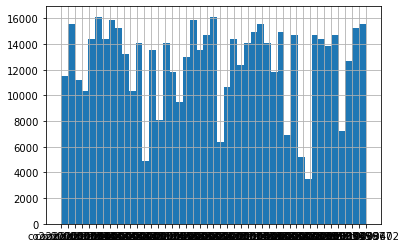

In [4]:
df_power['sub'].hist(bins=df_power['sub'].nunique())

# Default values

In [5]:
# Dataset 2
def_values_power = {
    'Artifact Removed': 'Yes',
    'EEG': 'Raw', 
    'Filter': 'Butterworth', 
    'Time': '-750ms', 
    'Method': 'Welch'
}
hue_order_power = {
    'Artifact Removed': ['Yes', 'No'],
    'EEG': ['Raw', 'Hjorth', 'M1 Average'], 
    'Filter': ['Blackmann-Harris', 'Butterworth'], 
    'Time': ['-250ms', '-750ms'], 
    'Method': ['FFT', 'Welch', 'Burg']
}
def_values_phase = {
    'Artifact Removed': 'Yes',
    'EEG': 'Raw',
    'Filter': 'Butterworth', 
}

# PSDs across trial

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


--------------
Artifact Removed
--------------
Performing EEG = Raw for constant Artifact Removed, shape = (1104, 13)
Performing Filter = Butterworth for constant Artifact Removed, shape = (552, 13)
Performing Time = -750ms for constant Artifact Removed, shape = (276, 13)
Performing Method = Welch for constant Artifact Removed, shape = (92, 13)
--------------
EEG
--------------
Performing Artifact Removed = Yes for constant EEG, shape = (1656, 13)
Performing Filter = Butterworth for constant EEG, shape = (828, 13)
Performing Time = -750ms for constant EEG, shape = (414, 13)
Performing Method = Welch for constant EEG, shape = (138, 13)
--------------
Filter
--------------
Performing Artifact Removed = Yes for constant Filter, shape = (1656, 13)
Performing EEG = Raw for constant Filter, shape = (552, 13)
Performing Time = -750ms for constant Filter, shape = (276, 13)
Performing Method = Welch for constant Filter, shape = (92, 13)
--------------
Time
--------------
Performing Artifact Rem

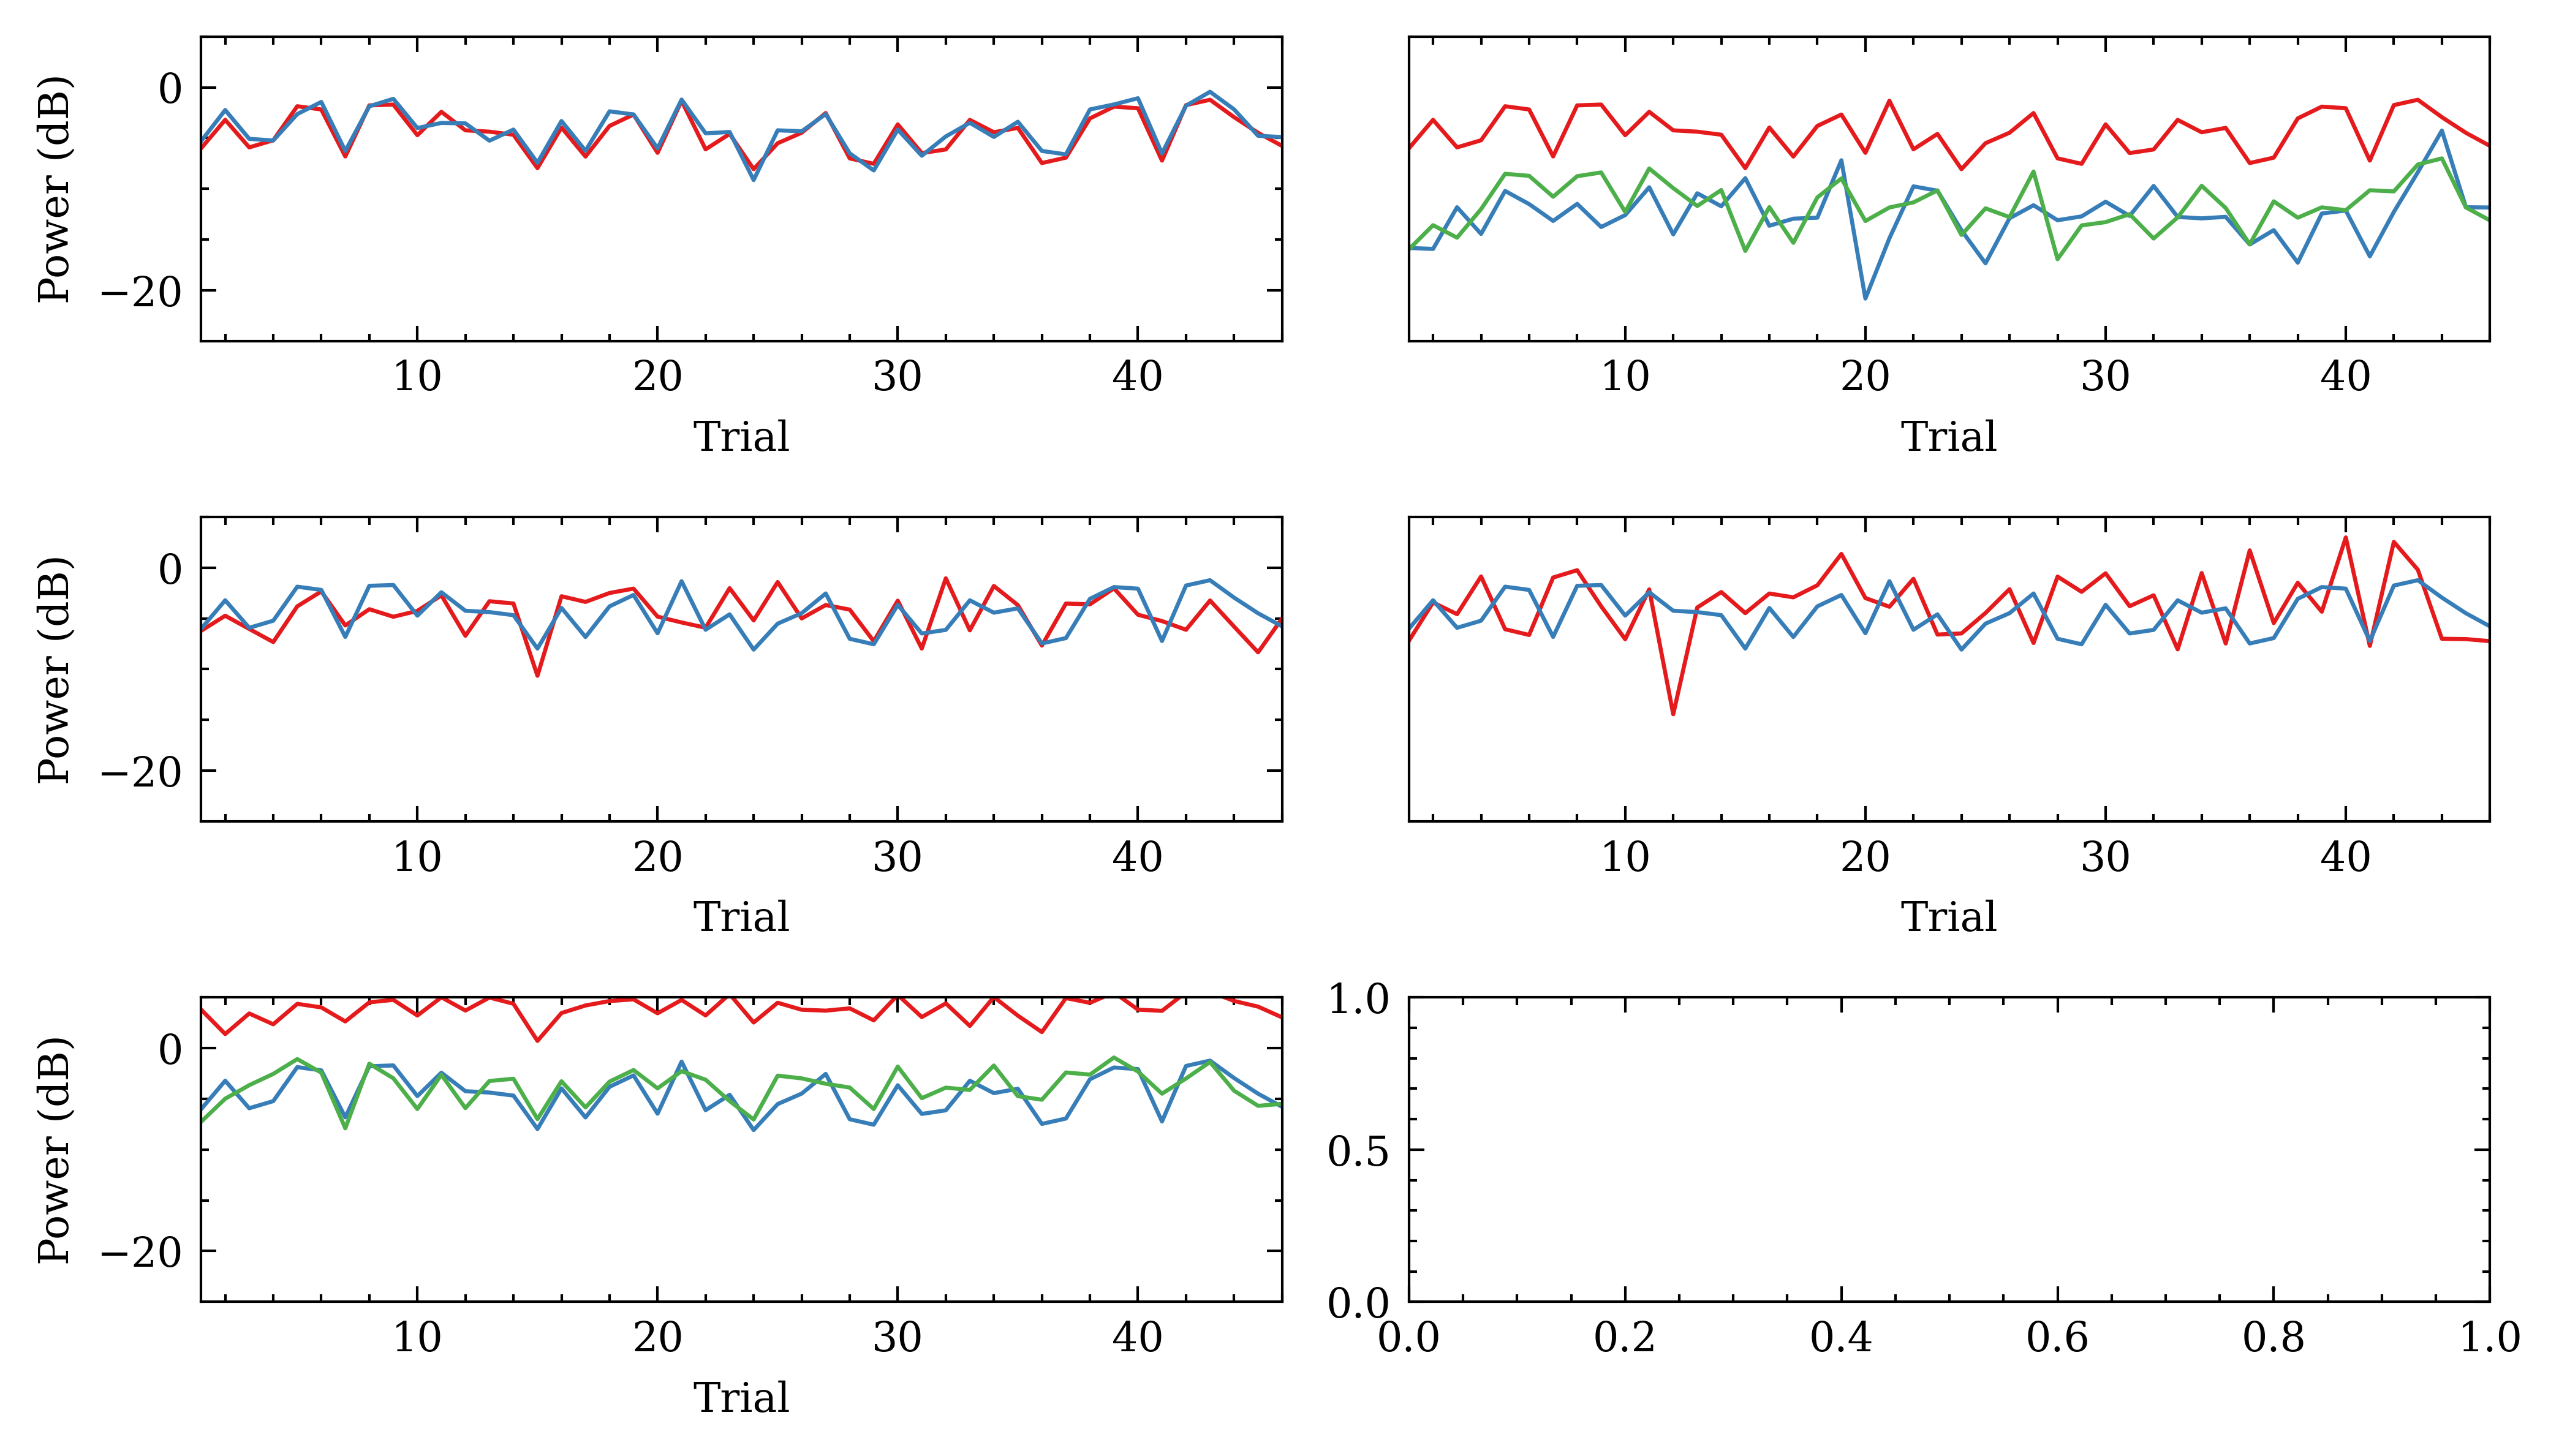

In [6]:
df_subject = df_power[df_power['sub'] == df_power['sub'].unique()[9]]
eegplot.power_trial_plot(df_subject, 'Beta', def_values_power, hue_order_power, y_lim=[-25, 5], show_legend=False)

# Box plots - PSD

--------------
Artifact Removed
--------------
Performing EEG = Raw for constant Artifact Removed, shape = (3456, 13)
Performing Filter = Butterworth for constant Artifact Removed, shape = (1728, 13)
Performing Time = -750ms for constant Artifact Removed, shape = (864, 13)
Performing Method = Welch for constant Artifact Removed, shape = (288, 13)
--------------
EEG
--------------
Performing Artifact Removed = Yes for constant EEG, shape = (5184, 13)
Performing Filter = Butterworth for constant EEG, shape = (2592, 13)
Performing Time = -750ms for constant EEG, shape = (1296, 13)
Performing Method = Welch for constant EEG, shape = (432, 13)
--------------
Filter
--------------
Performing Artifact Removed = Yes for constant Filter, shape = (5184, 13)
Performing EEG = Raw for constant Filter, shape = (1728, 13)
Performing Time = -750ms for constant Filter, shape = (864, 13)
Performing Method = Welch for constant Filter, shape = (288, 13)
--------------
Time
--------------
Performing Artifa

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


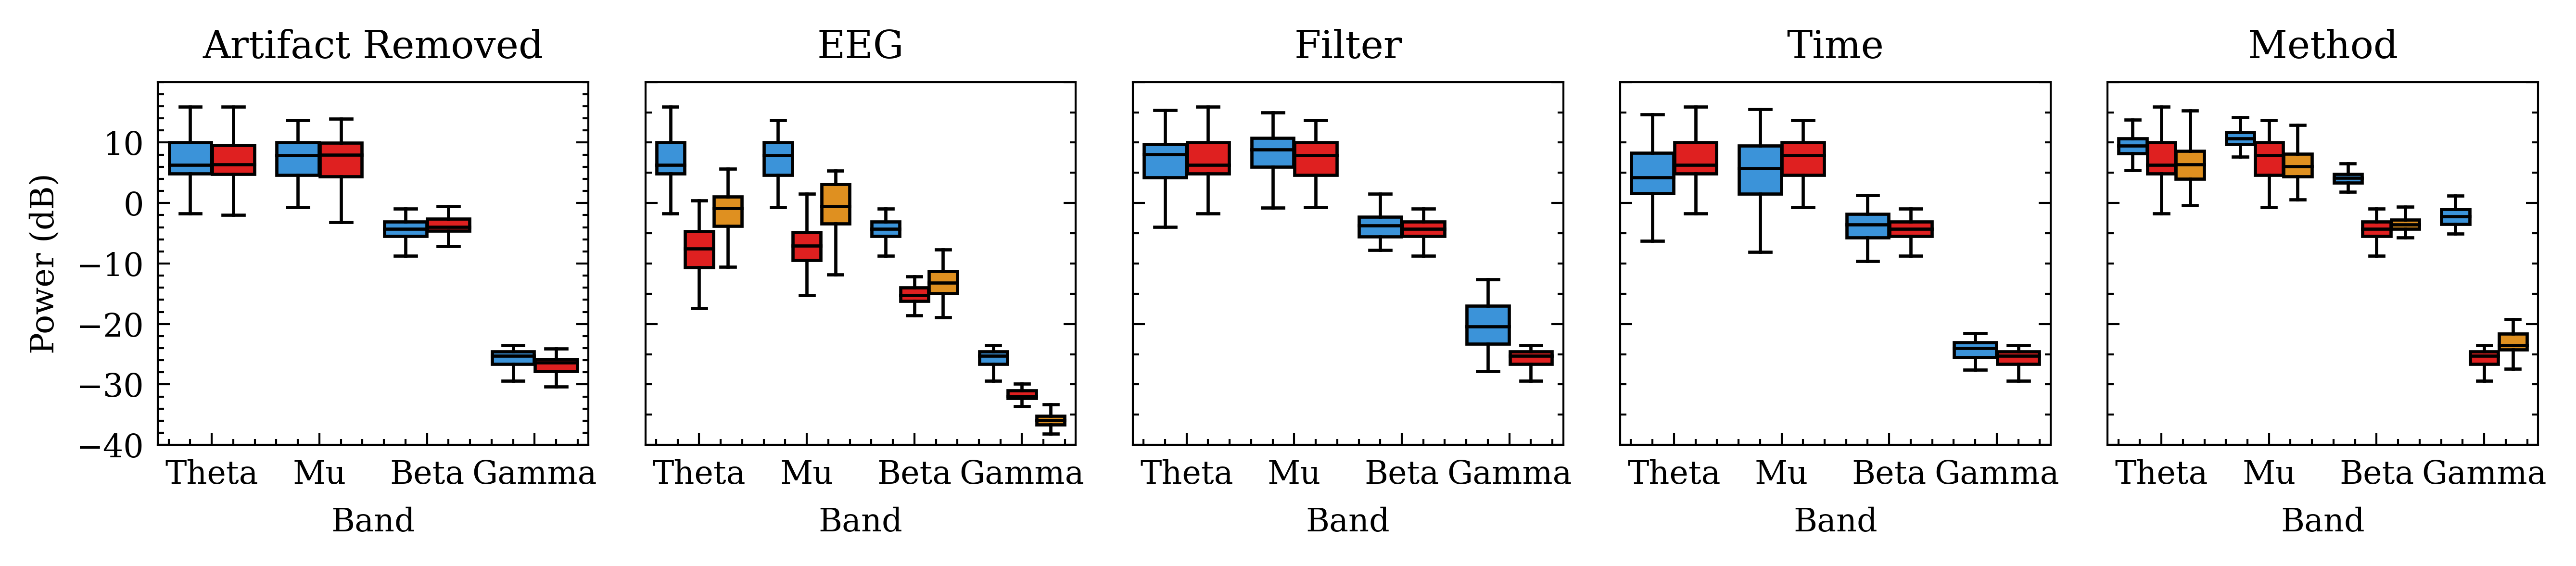

In [7]:
df_subject = df_power[df_power['sub'] == df_power['sub'].unique()[10]]
eegplot.power_box_plot(df_subject, def_values_power, hue_order_power, y_lim=[-40, 20], y_ticks=[-40, -30, -20, -10, 0, 10], show_legend=False)
# eegplot.power_violin_plot(df_subject, def_values_power, hue_order_power, y_lim=[-40, 10], y_ticks=[-40, -30, -20, -10, 0, 10], show_legend=True)

# Interaction plot - PSD

Plotting in (0, 0): ('Artifact Removed', 'EEG'), shape: (216, 13), unique1: ['No' 'Yes'], unique2: ['Raw' 'Hjorth' 'M1 Average']
Plotting in (0, 1): ('Artifact Removed', 'Filter'), shape: (144, 13), unique1: ['No' 'Yes'], unique2: ['Butterworth' 'Blackmann-Harris']
Plotting in (0, 2): ('Artifact Removed', 'Time'), shape: (144, 13), unique1: ['No' 'Yes'], unique2: ['-750ms' '-250ms']
Plotting in (0, 3): ('Artifact Removed', 'Method'), shape: (216, 13), unique1: ['No' 'Yes'], unique2: ['Burg' 'Welch' 'FFT']
Plotting in (0, 4): ('EEG', 'Filter'), shape: (216, 13), unique1: ['Raw' 'Hjorth' 'M1 Average'], unique2: ['Butterworth' 'Blackmann-Harris']
Plotting in (1, 0): ('EEG', 'Time'), shape: (216, 13), unique1: ['Raw' 'Hjorth' 'M1 Average'], unique2: ['-750ms' '-250ms']
Plotting in (1, 1): ('EEG', 'Method'), shape: (324, 13), unique1: ['Raw' 'Hjorth' 'M1 Average'], unique2: ['Burg' 'Welch' 'FFT']
Plotting in (1, 2): ('Filter', 'Time'), shape: (144, 13), unique1: ['Butterworth' 'Blackmann-Ha

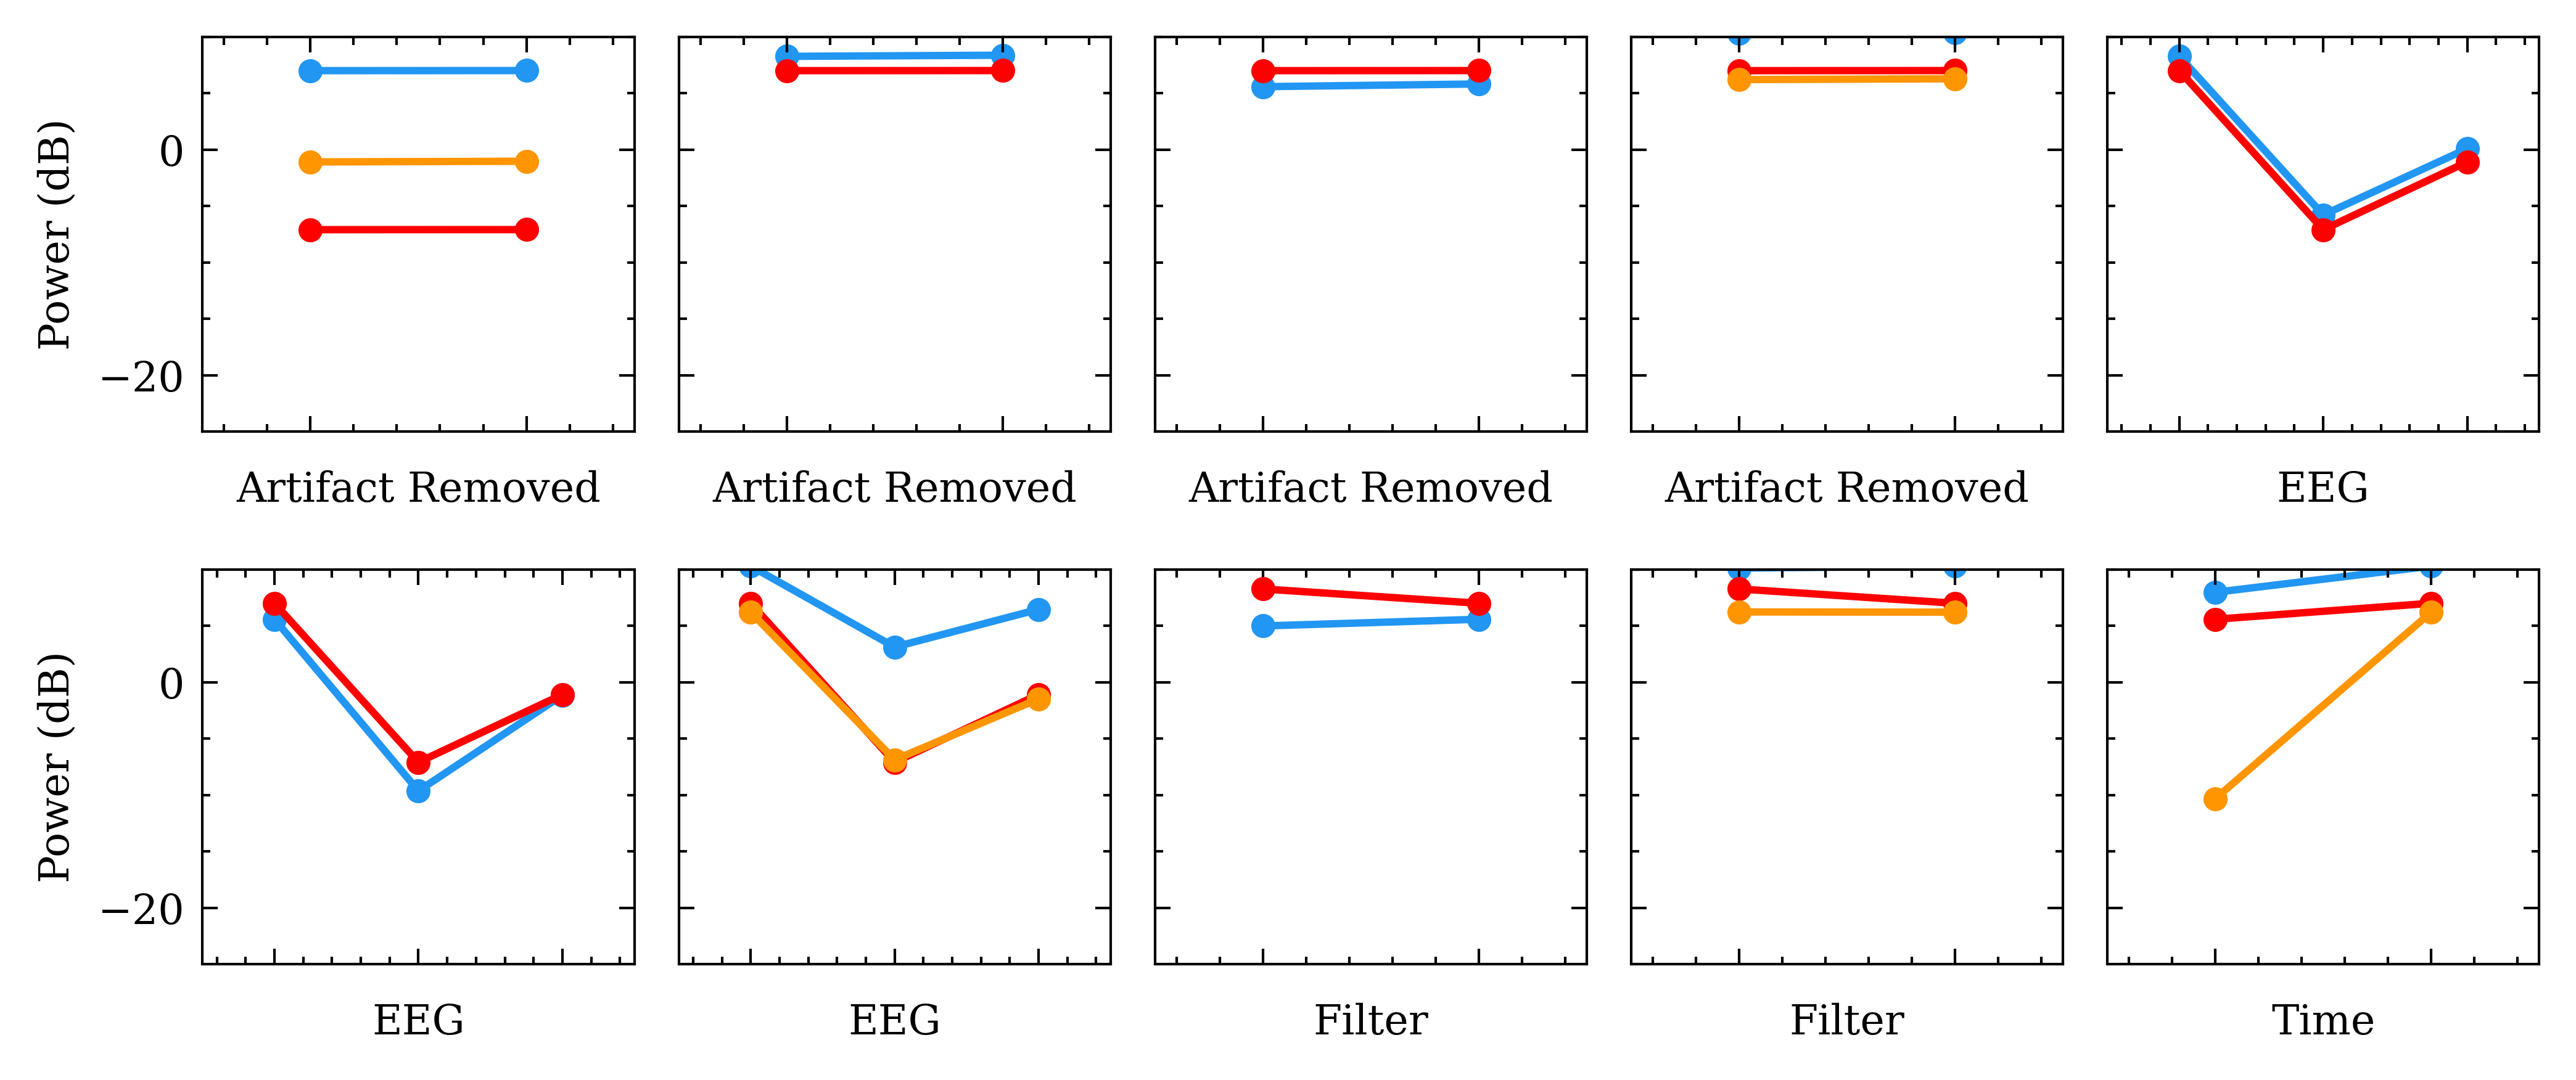

In [8]:
df_subject = df_power[df_power['sub'] == df_power['sub'].unique()[10]]
eegplot.power_interaction_plot(df_subject, def_values_power, 'Mu', hue_order_power, y_lim=[-25, 10], show_legend=False, hide_tick_labels=True)

# Histogram - phases

Artifact Removed, Band: Theta, Options: ['No' 'Yes']
Artifact Removed, Band: Mu, Options: ['No' 'Yes']
Artifact Removed, Band: Beta, Options: ['No' 'Yes']
Artifact Removed, Band: Gamma, Options: ['No' 'Yes']
EEG, Band: Theta, Options: ['Raw' 'Hjorth' 'M1 Average']
EEG, Band: Mu, Options: ['Raw' 'Hjorth' 'M1 Average']
EEG, Band: Beta, Options: ['Raw' 'Hjorth' 'M1 Average']
EEG, Band: Gamma, Options: ['Raw' 'Hjorth' 'M1 Average']
Filter, Band: Theta, Options: ['Butterworth' 'Blackmann-Harris']


/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

Filter, Band: Mu, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Beta, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Gamma, Options: ['Butterworth' 'Blackmann-Harris']



/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/alam/anaconda3/envs/eeg/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

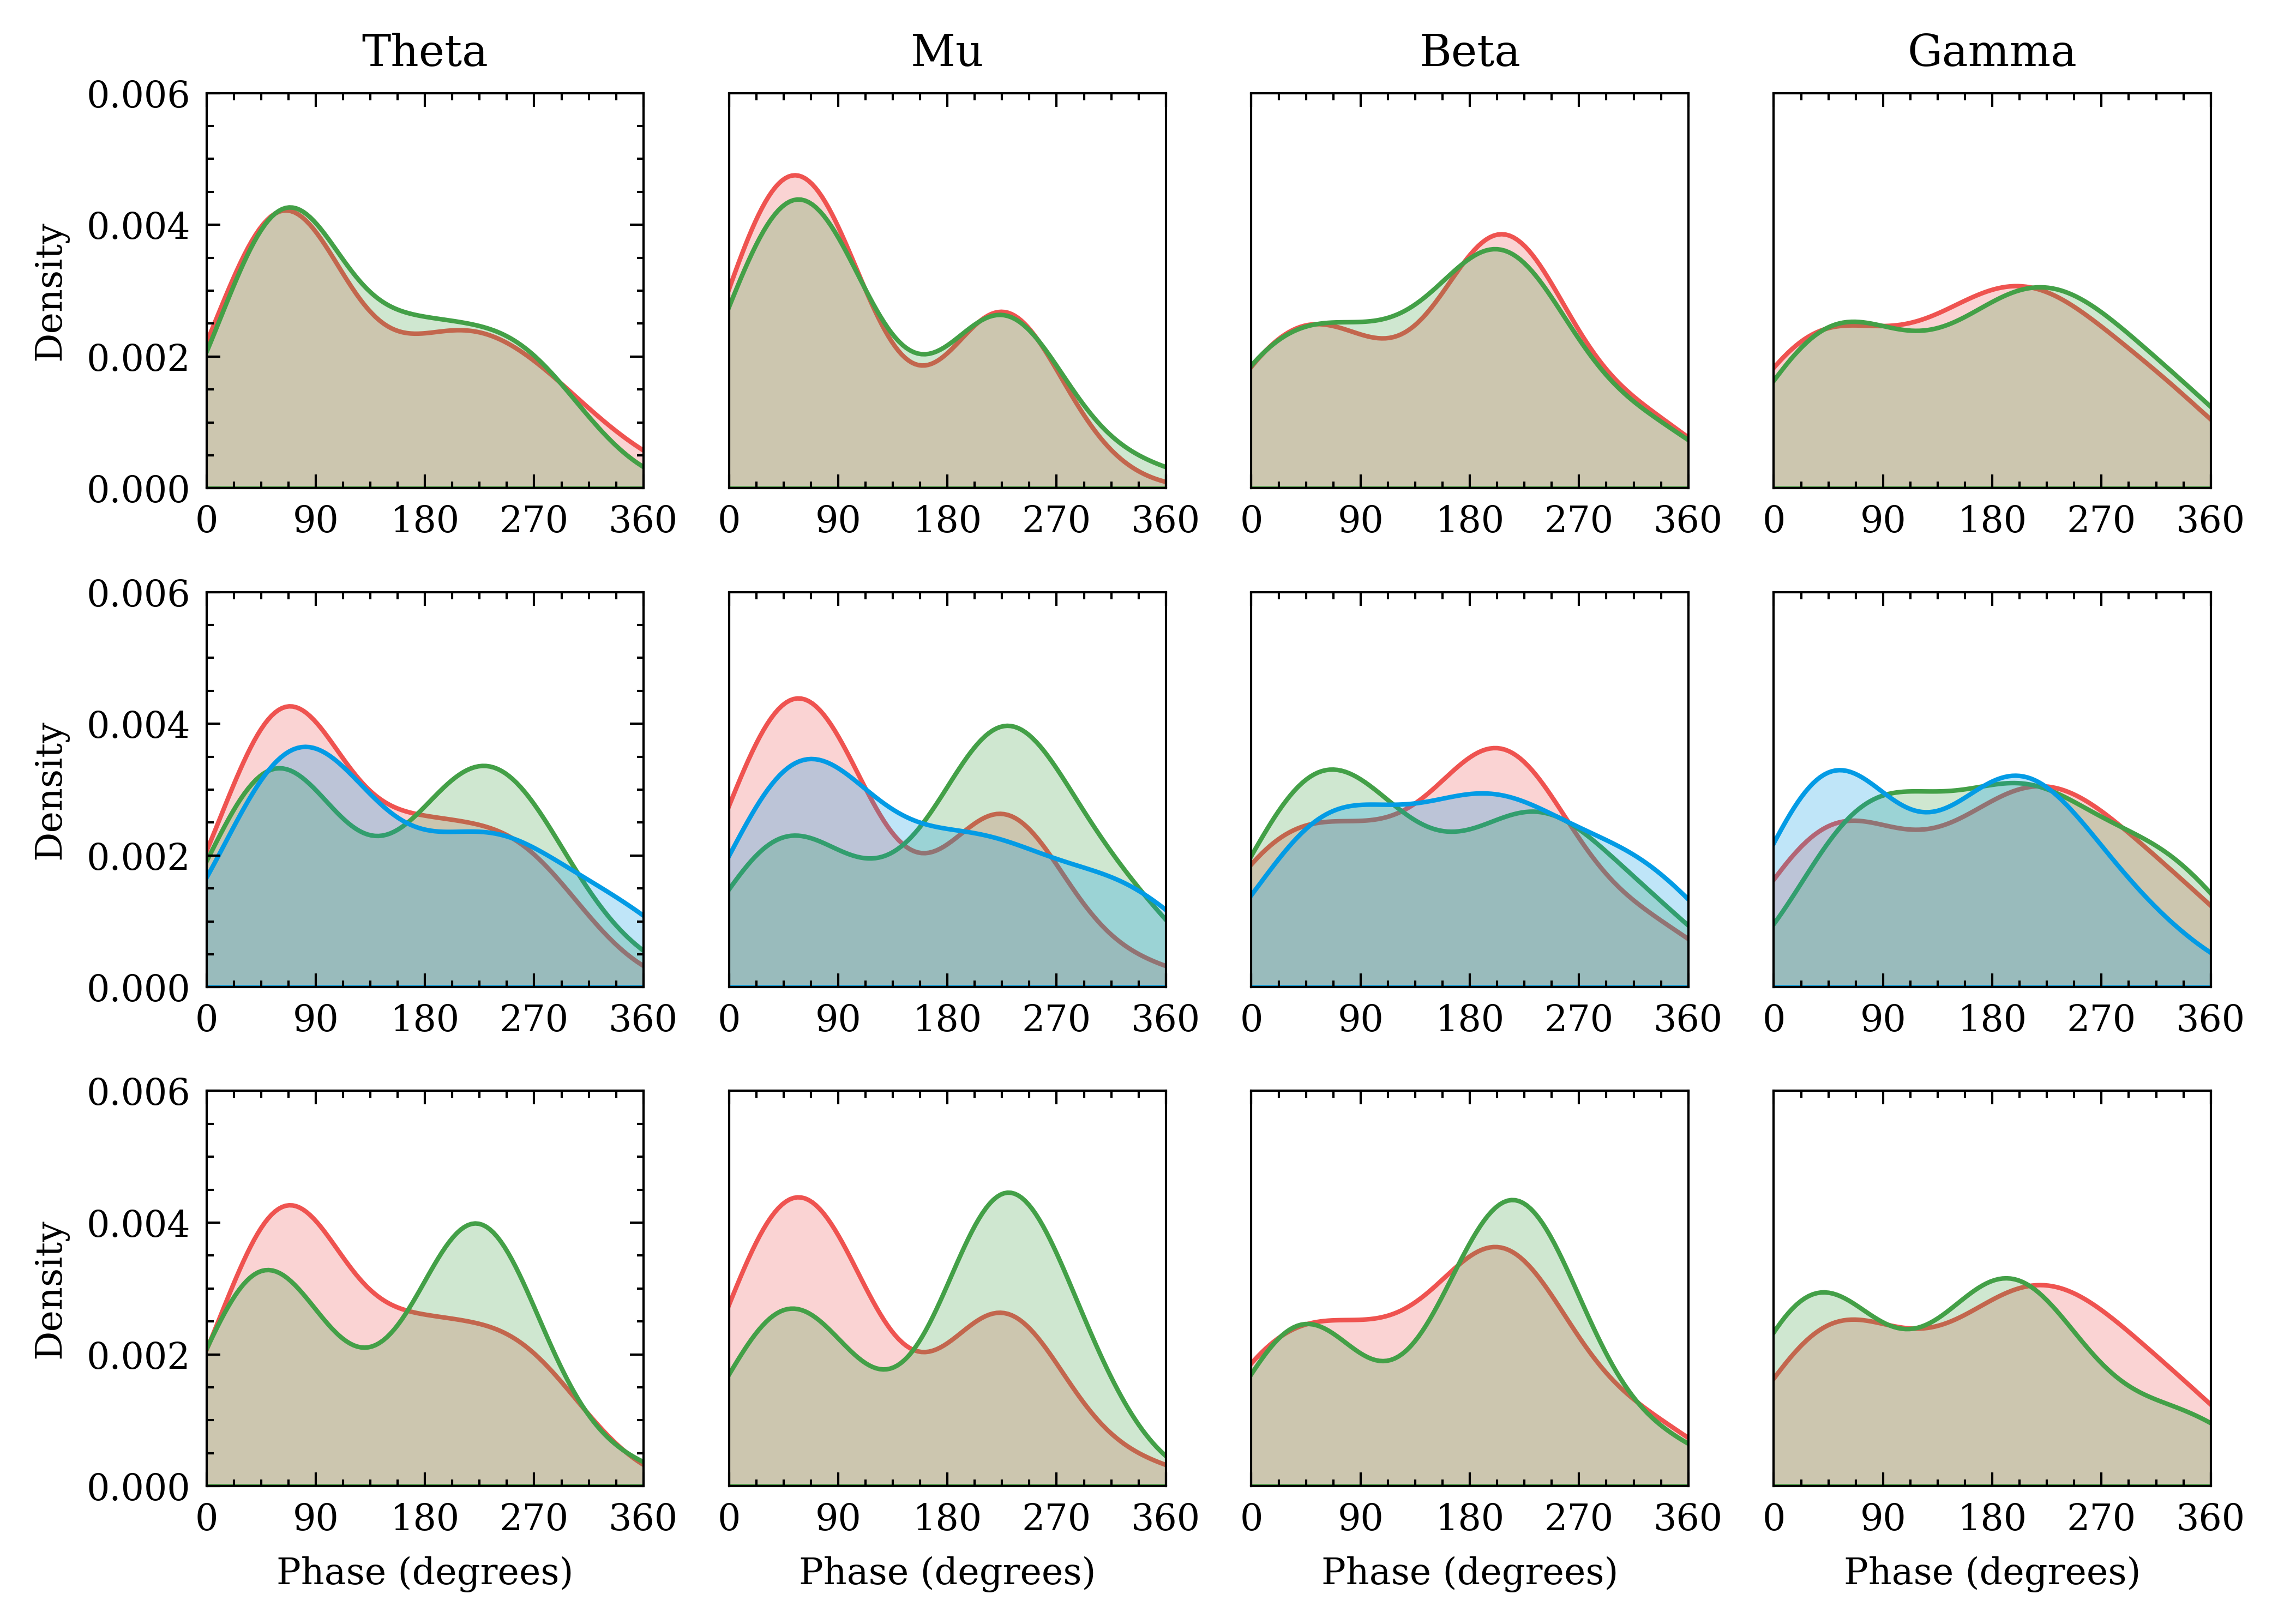

In [9]:
df_subject = df_phase[df_phase['sub'] == df_phase['sub'].unique()[10]]
eegplot.phase_hist_plot(df_subject, def_values_phase, y_lim=[0, 0.006])

# Correlation - power

In [10]:
print(df_power.shape)
df_power = df_power[~df_power['Power'].isin([np.nan, np.inf, -np.inf])]
print(df_power.shape)

(565344, 13)
(564720, 13)


In [11]:
df_corr = []
for sub in tqdm(df_power['sub'].unique()):
    df_sub = df_power[df_power['sub'] == sub]
    for key, val in def_values_power.items():
        df2 = df_sub
        for key2, val2 in def_values_power.items():
            if key != key2:
                df2 = df2[df2[key2] == val2]
        combs = list(combinations(sorted(df2[key].unique()), 2))
        for band in df_power['Band'].unique():
            df3 = df2[df2['Band'] == band]
            for value_pair in combs:
                data1 = df3[df3[key] == value_pair[0]]['Power'].values
                data2 = df3[df3[key] == value_pair[1]]['Power'].values
                mn = min(len(data1), len(data2))
                data1 = data1[0:mn]
                data2 = data2[0:mn]
                corr, _ = pearsonr(data1, data2)
                # print('sub: {}, band: {}, factor: {}, shape: [{}, {}]'.format(sub, band, key, data1.shape[0], data2.shape[0]))
                df_corr.append({
                    'subject': sub,
                    'band': band,
                    'factor': key,
                    'value_1': value_pair[0],
                    'value_2': value_pair[1],
                    'Correlation': corr
                })

In [12]:
df_corr = pd.DataFrame(df_corr)
df_corr['factor_value'] = df_corr.apply(lambda x: '{}: {} vs {}'.format(x['factor'], x['value_1'], x['value_2']), axis=1)
df_corr.head()

,subject,band,factor,value_1,value_2,Correlation,factor_value
0,co2c0000337,Theta,Artifact Removed,No,Yes,0.953273,Artifact Removed: No vs Yes
1,co2c0000337,Mu,Artifact Removed,No,Yes,0.981694,Artifact Removed: No vs Yes
2,co2c0000337,Beta,Artifact Removed,No,Yes,0.978586,Artifact Removed: No vs Yes
3,co2c0000337,Gamma,Artifact Removed,No,Yes,0.803665,Artifact Removed: No vs Yes
4,co2c0000337,Theta,EEG,Hjorth,M1 Average,-0.123749,EEG: Hjorth vs M1 Average


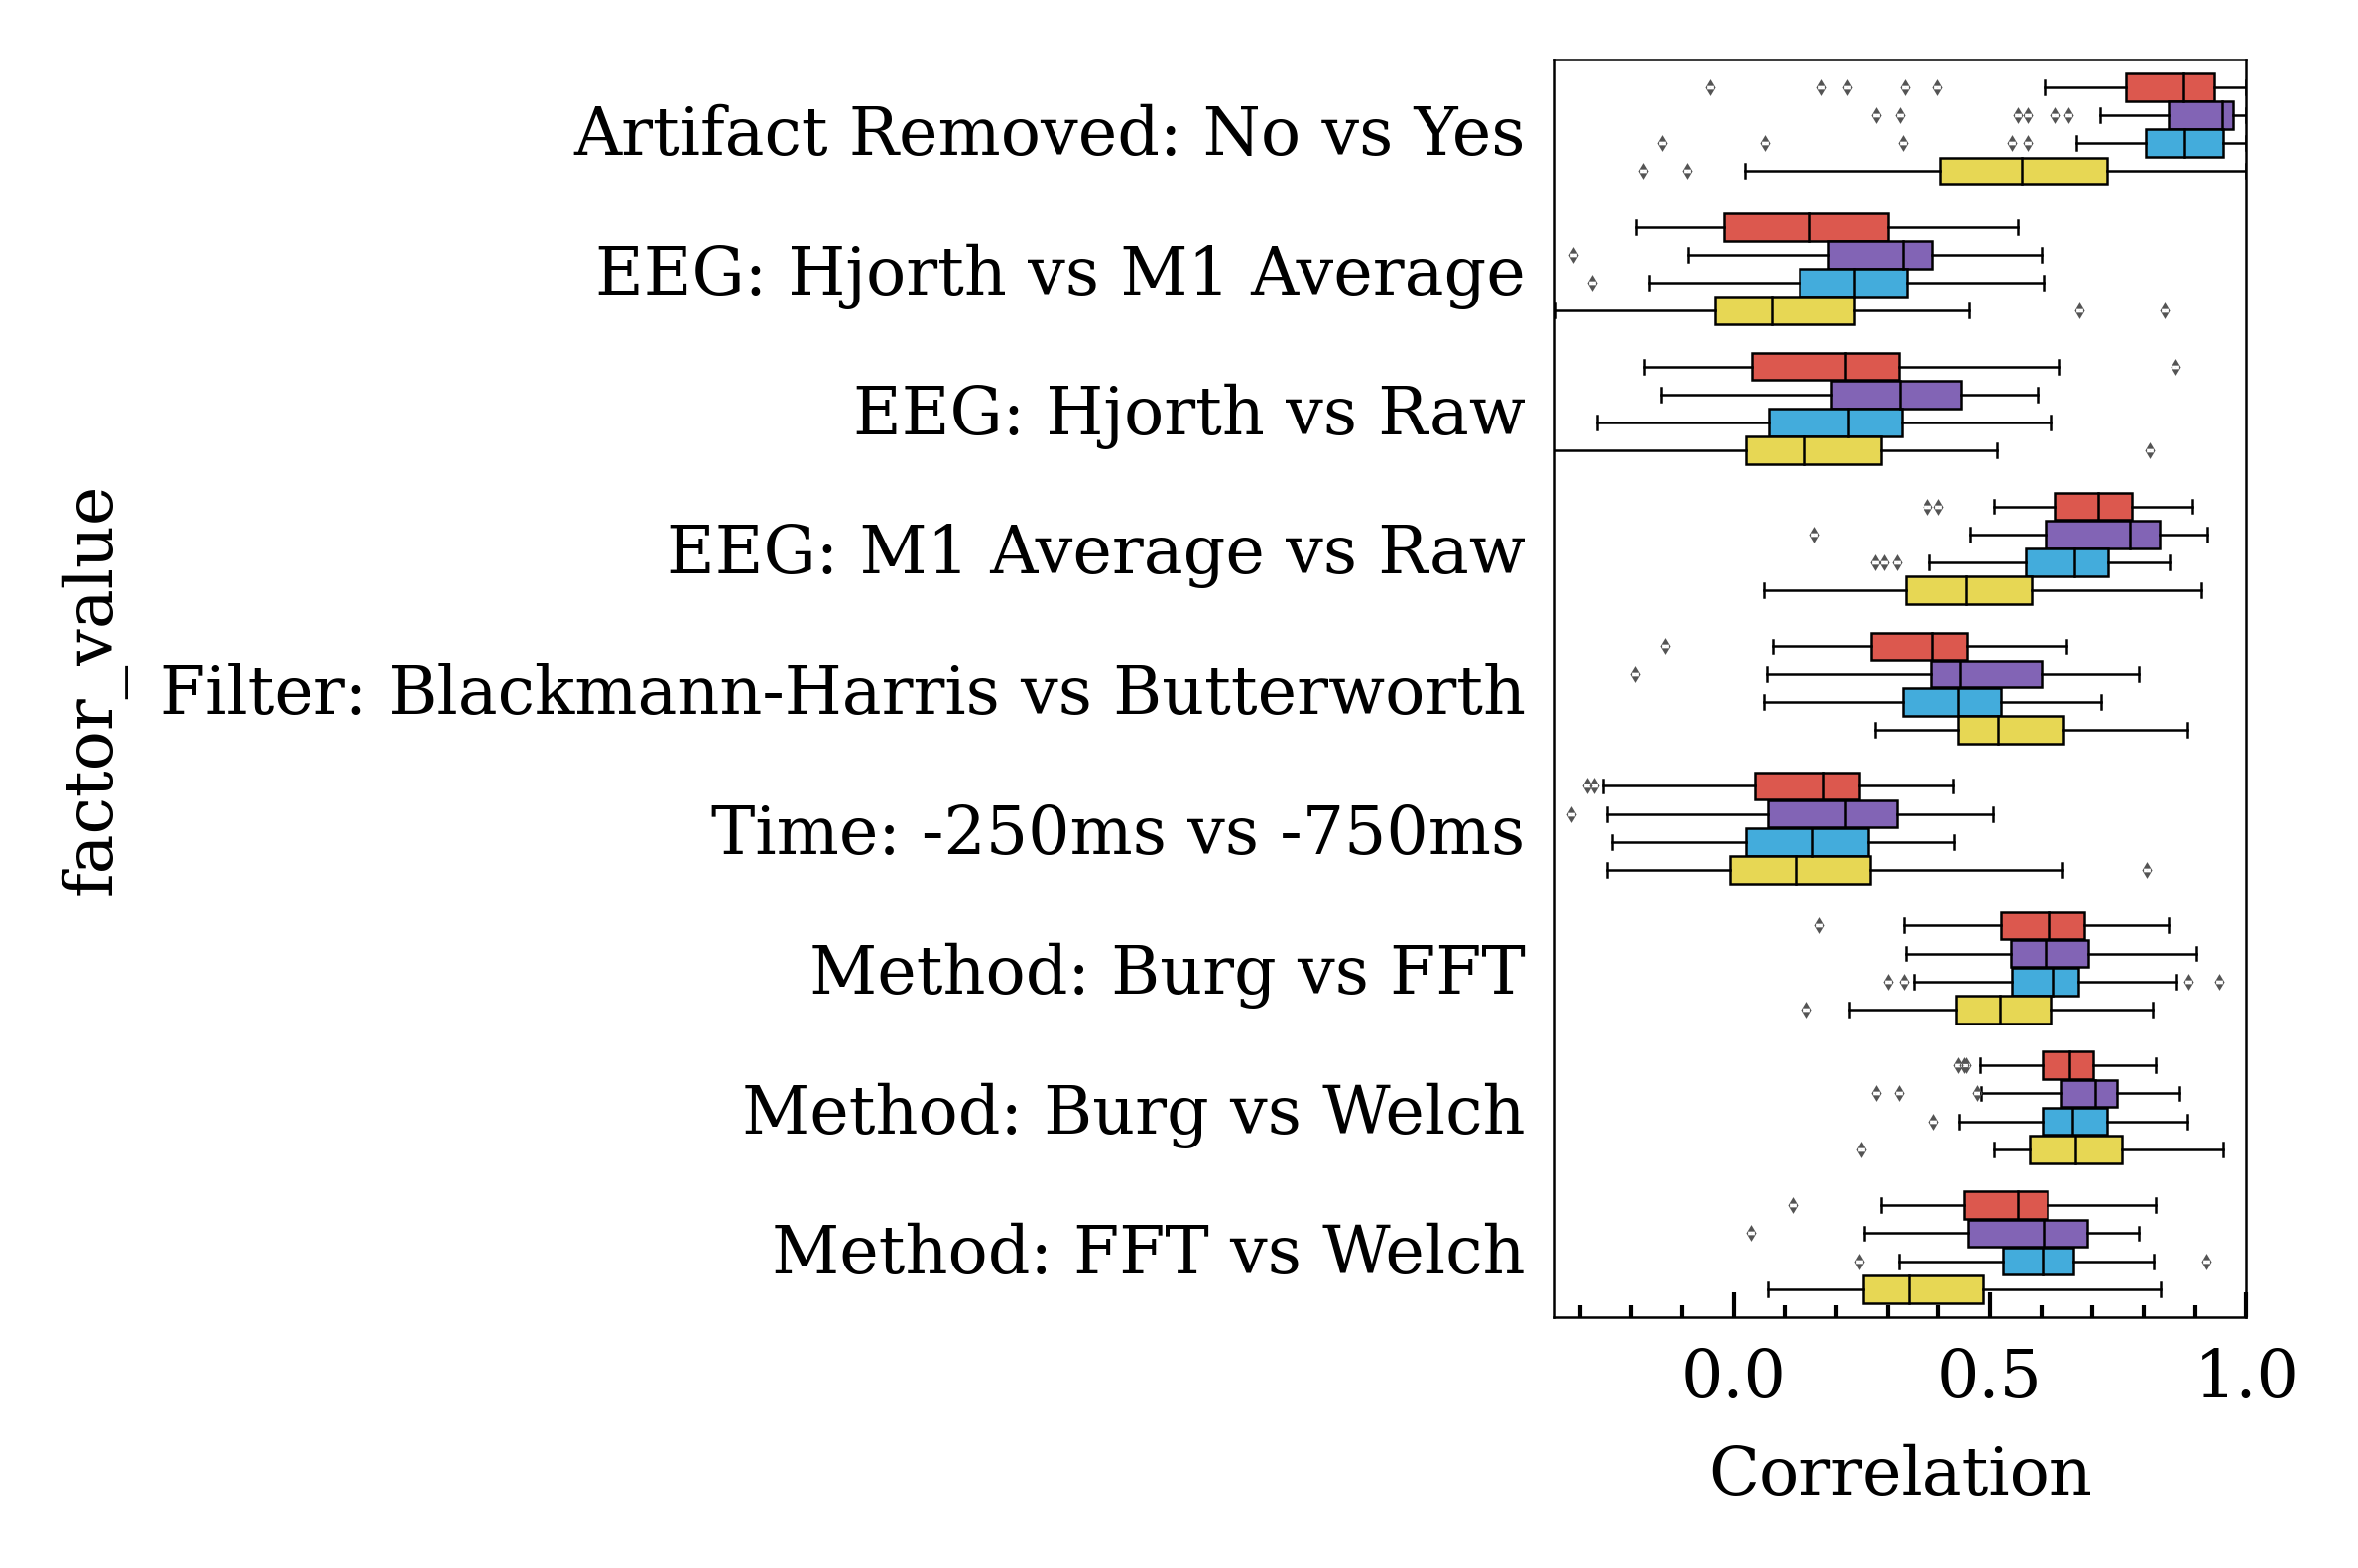

In [13]:
eegplot.power_corr_plot(df_corr, x_lim=[-0.35, 1], x_ticks=[0, 0.5, 1])
# eegplot.power_corr_plot_violin(df_corr, x_lim=[-0.35, 2], x_ticks=[0, 0.5, 1])

# Correlation - phase

In [14]:
df_phase_peak = df_phase[df_phase['Phase'] < 180]
df_phase_trough = df_phase[df_phase['Phase'] >= 180]

df_corr = []
for grp_name, df_phase_grp in zip(['peak', 'trough'], [df_phase_peak, df_phase_trough]):
    for sub in tqdm(df_phase_grp['sub'].unique()):
        df_sub = df_phase_grp[df_phase_grp['sub'] == sub]
        for key, val in def_values_phase.items():
            df2 = df_sub
            for key2, val2 in def_values_phase.items():
                if key != key2:
                    df2 = df2[df2[key2] == val2]
            combs = list(combinations(sorted(df2[key].unique()), 2))
            for band in df_phase['Band'].unique():
                df3 = df2[df2['Band'] == band]
                for value_pair in combs:
                    data1 = df3[df3[key] == value_pair[0]]['Phase'].values
                    data2 = df3[df3[key] == value_pair[1]]['Phase'].values
                    mn = np.min([data1.shape[0], data2.shape[0]])
                    data1 = data1[0:mn]
                    data2 = data2[0:mn]
                    corr, _ = pearsonr(data1, data2)
                    # print('sub: {}, band: {}, factor: {}, shape: [{}, {}]'.format(sub, band, key, data1.shape[0], data2.shape[0]))
                    df_corr.append({
                        'subject': sub,
                        'band': band,
                        'group': grp_name,
                        'factor': key,
                        'value_1': value_pair[0],
                        'value_2': value_pair[1],
                        'Correlation': corr
                    })
                    
df_corr = pd.DataFrame(df_corr)
df_corr['factor_value'] = df_corr.apply(lambda x: '{}: {} vs {}'.format(x['factor'], x['value_1'], x['value_2']), axis=1)
df_corr.head()

,subject,band,group,factor,value_1,value_2,Correlation,factor_value
0,co2c0000337,Theta,peak,Artifact Removed,No,Yes,0.341070,Artifact Removed: No vs Yes
1,co2c0000337,Mu,peak,Artifact Removed,No,Yes,0.994313,Artifact Removed: No vs Yes
2,co2c0000337,Beta,peak,Artifact Removed,No,Yes,0.117576,Artifact Removed: No vs Yes
3,co2c0000337,Gamma,peak,Artifact Removed,No,Yes,0.063949,Artifact Removed: No vs Yes
4,co2c0000337,Theta,peak,EEG,Hjorth,M1 Average,0.014690,EEG: Hjorth vs M1 Average


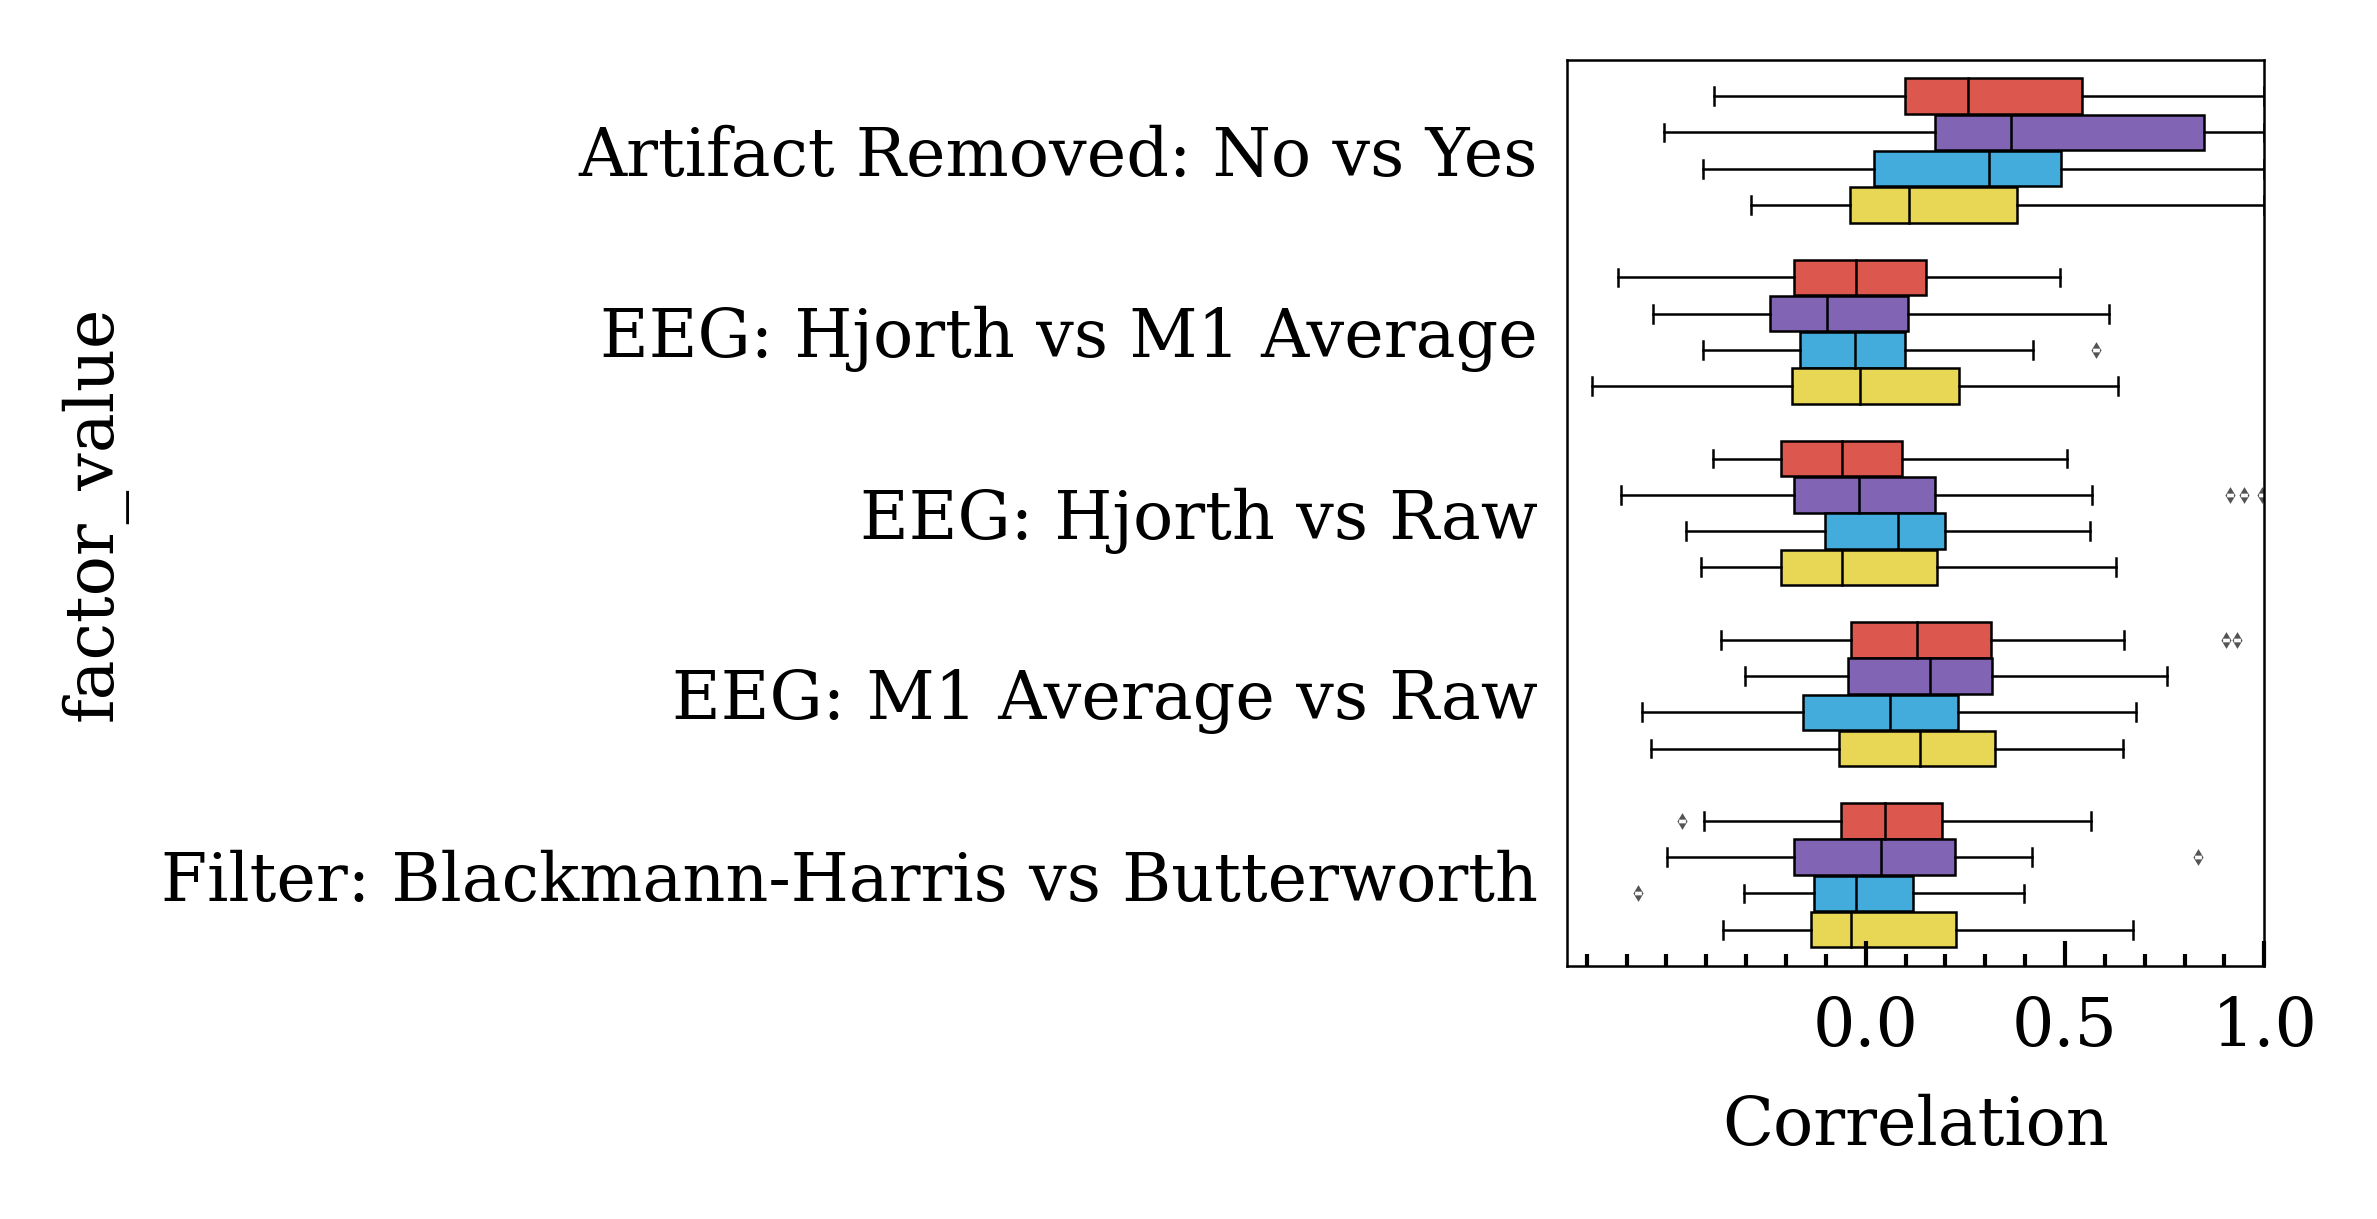

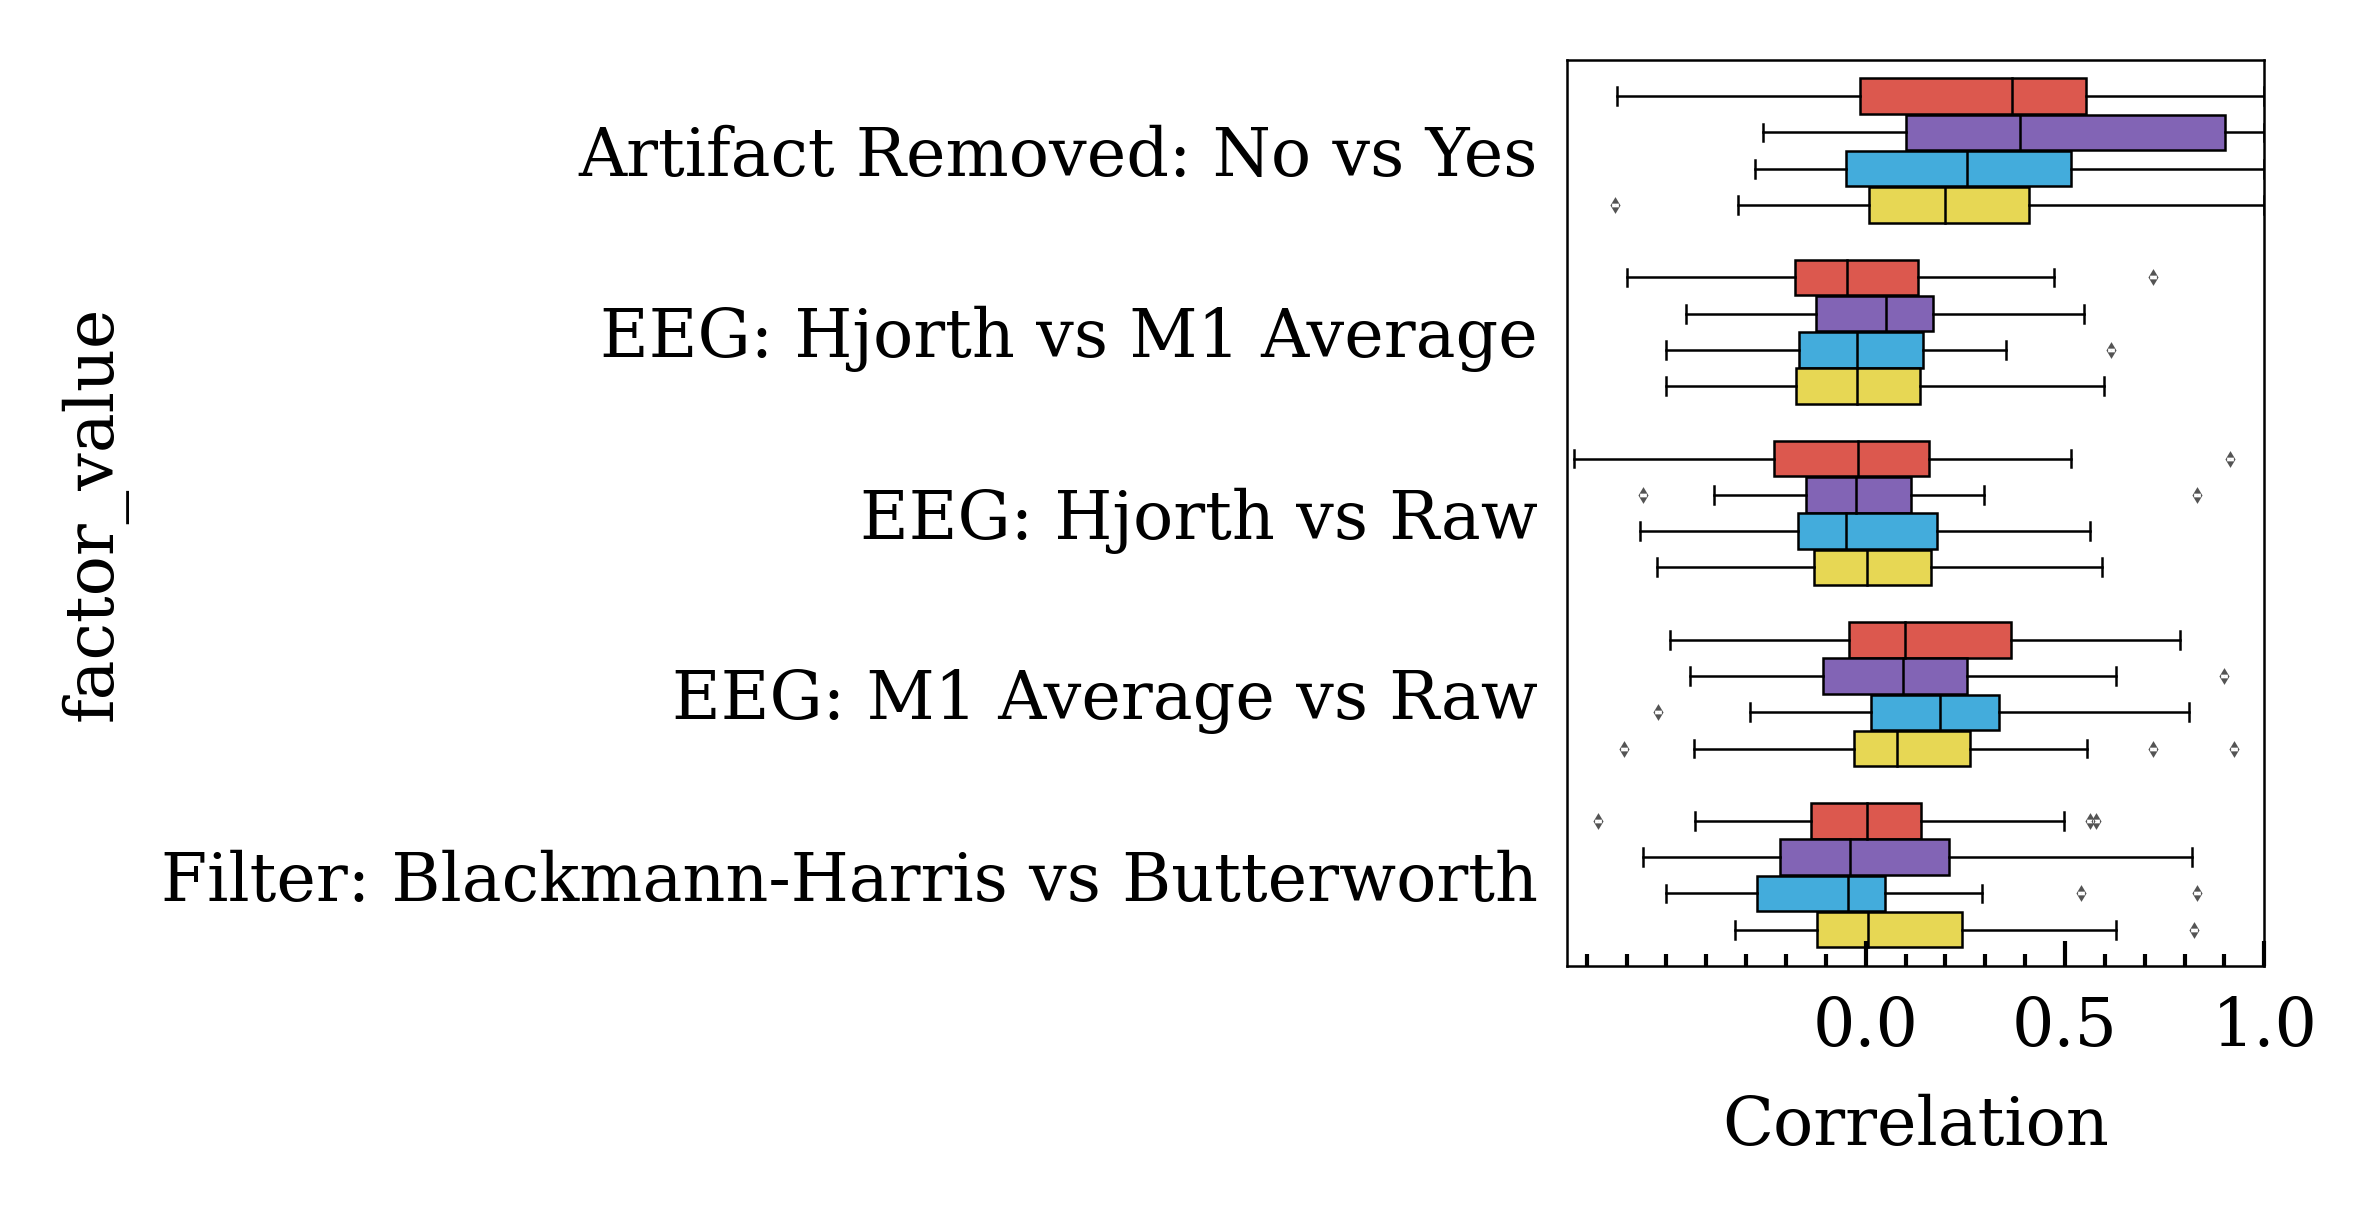

In [15]:
eegplot.phase_corr_plots(df_corr, x_lim=[-.75, 1], x_ticks=[0, 0.5, 1])